# Solve Grid World with Multiple Tasks

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import scriptinit
import numpy as np
import numpy.linalg as npla
import matplotlib
import pylab as plt
import time
from IPython import display
from gridworld import Grid, GridWorldMDP, GridWorld
from agent import ValueIterationSolver, TDLearner, DQN, RecurrentReinforceAgent

In [2]:
def solve_by_value_iteration(grid, rewards):
    # Solve the grid using value iteration as a sanity check
    mdp = GridWorldMDP(grid, rewards, wall_penalty=0., gamma=0.9)
    mdp_agent = ValueIterationSolver(mdp, tol=1e-6)
    mdp_agent.learn()

    # visualize the results
    values = np.zeros(world.shape)
    for state in xrange(grid.get_num_states()):
        values[grid.state_pos[state]] = mdp_agent.V[state]

    expected_reward = np.sum(values) / float(world.shape[0] * world.shape[1] - np.sum(world) - len(rewards))

    # put the terminal state rewards in for visualization purposes
    for pos, r in rewards.items():
        values[pos] = r

    print values
    print 'Expected reward', expected_reward
    return values

## Solve gridworld using a DQN

In [3]:
# diagnostic function
def compute_value_function(episode, total_reward):
    global GT
    print 'Episode number: ',  episode
    values = np.zeros(world.shape)
    for row in xrange(world.shape[0]):
        for col in xrange(world.shape[1]):
            if world[row, col] == 0:  # agent can occupy this state
                agent_state = np.zeros_like(world)
                agent_state[row, col] = 1.
                state = agent_state.ravel().reshape(-1, 1)

                qvals = dqn.fprop(state.T)
                values[row, col] = np.max(qvals)

    for pos, r in rewards.items():
        values[pos] = r

    print values, '\n'
    
    error = npla.norm(values - GT, 'fro')
    return error

In [1]:
# template for interaction between the agent and the task
def grid_experiment(agent, task, num_episodes, diagnostic_callback=None, diagnostic_frequency=100):
    episodes = []
    errors = []

    for episode in xrange(NUM_EPISODES):
        total_reward = 0.
        while grid_task.is_terminal():
            grid_task.reset()

        curr_state = grid_task.get_current_state()
        num_steps = 0.
        while True:
            num_steps += 1
            if num_steps > 200:
                print 'Lying and tell the agent the episode is over!'
                agent.end_episode(0)
                num_steps = 0.

            action = agent.get_action(curr_state)
            next_state, reward = grid_task.perform_action(action)
            total_reward += reward
            if grid_task.is_terminal():
                agent.end_episode(reward)
                break
            else:
                agent.learn(next_state, reward)
                curr_state = next_state
        
        if episode % diagnostic_frequency == 0:
            if diagnostic_callback is not None:
                error = diagnostic_callback(episode, total_reward)
                episodes.append(episode)
                errors.append(error)
                
    # plot convergence curve.
    if errors:
        plt.cla()
        plt.plot(episodes, errors)
        # display.clear_output(wait=True)
#         display.display(plt.gcf())
#         plt.close()

In [18]:
# set up a very simple world with a single wall
world = np.zeros((3, 4))
world[1, 1] = 1.
grid = Grid(world, action_stoch=0.2)
# set up rewards.
rewards = {(0, 3): 1., (1, 3): -1.}
# get ground truth by value iteration method.
GT = solve_by_value_iteration(grid, rewards)

[[ 0.74571474  0.84849719  0.96545788  1.        ]
 [ 0.65555608  0.          0.75177567 -1.        ]
 [ 0.57964931  0.57734331  0.65267736  0.49373426]]
Expected reward 0.696711756054


Since the world has 3 $\times$ 4 = 12 states, it seems invalid to use no less than 12 hidden hidden dimensions. 

Here let's try hidden_dim = 6, to force states to share representation.

Compiling fprop
Compiling backprop
done
Episode number:  0
[[ 0.32108131  0.63326699  0.19658055  1.        ]
 [ 1.27946293  0.          0.         -1.        ]
 [-0.00211963  0.0122945   0.20429677  0.29038599]] 

Lying and tell the agent the episode is over!
Lying and tell the agent the episode is over!
Lying and tell the agent the episode is over!
Lying and tell the agent the episode is over!
Lying and tell the agent the episode is over!
Episode number:  1000
[[ 0.79739915  0.89134755  0.97693463  1.        ]
 [ 0.68483237  0.          0.83935829 -1.        ]
 [ 0.68195288  0.64026948  0.66516908  0.5728561 ]] 

Episode number:  2000
[[ 0.75321016  0.84371578  0.964056    1.        ]
 [ 0.62378496  0.          0.70818683 -1.        ]
 [ 0.57704787  0.52325093  0.61751304  0.24281951]] 

Episode number:  3000
[[ 0.6929378   0.81107969  0.93870077  1.        ]
 [ 0.62402495  0.          0.68754756 -1.        ]
 [ 0.54271945  0.51892253  0.58306556  0.38504531]] 

Episode number:  4000

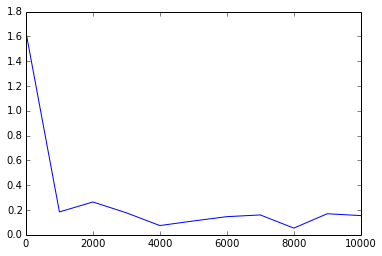

In [15]:
# setup task and agent
NUM_EPISODES = 10001
grid_task = GridWorld(grid, rewards, wall_penalty=0., gamma=0.9, tabular=False)
dqn = DQN(grid_task, hidden_dim=6, l2_reg=0.0, lr=0.05, epsilon=0.15)
# run the experiment
grid_experiment(dqn, grid_task, NUM_EPISODES, diagnostic_callback=compute_value_function, diagnostic_frequency=1000)

Compiling fprop
Compiling backprop
done
Episode number:  0
[[ 0.04422166  0.06759449  0.04271118  1.        ]
 [ 0.35346933  0.          0.01585327 -1.        ]
 [-0.04113312  0.02177264 -0.00970049  0.04357735]] 

Episode number:  1000
[[ 0.74535285  0.85613054  0.96030422  1.        ]
 [ 0.63042793  0.          0.77000129 -1.        ]
 [ 0.60228672  0.5490961   0.66403361  0.58317925]] 

Episode number:  2000
[[ 0.76977854  0.86443865  0.97720011  1.        ]
 [ 0.66025568  0.          0.80279356 -1.        ]
 [ 0.59097197  0.619044    0.72092066  0.59659731]] 

Episode number:  3000
[[ 0.79136806  0.88885913  0.98412043  1.        ]
 [ 0.7218801   0.          0.85484892 -1.        ]
 [ 0.6410162   0.6066898   0.67573719  0.4819416 ]] 

Episode number:  4000
[[ 0.75342968  0.84230124  0.94764536  1.        ]
 [ 0.67335062  0.          0.74886135 -1.        ]
 [ 0.560107    0.54462605  0.60898845  0.42976265]] 

Episode number:  5000
[[ 0.76711738  0.85564664  0.97176166  1.        ]


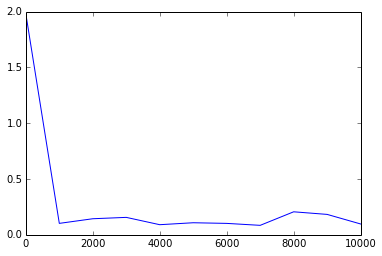

In [16]:
# setup task and agent
NUM_EPISODES = 10001
grid_task = GridWorld(grid, rewards, wall_penalty=0., gamma=0.9, tabular=False)
dqn = DQN(grid_task, hidden_dim=6, l2_reg=0.0, lr=0.05, epsilon=0.15)
# run the experiment
grid_experiment(dqn, grid_task, NUM_EPISODES, diagnostic_callback=compute_value_function, diagnostic_frequency=1000)

Compiling fprop
Compiling backprop
done
Lying and tell the agent the episode is over!
Episode number:  0
[[ 0.93114103  0.98097556  0.85501088  1.        ]
 [ 0.85312987  0.          0.85332726 -1.        ]
 [ 0.78492173  0.89196404  0.97692724  0.85983837]] 

Episode number:  1000
[[ 0.71822213  0.84009577  0.94575488  1.        ]
 [ 0.58401277  0.          0.5892375  -1.        ]
 [ 0.49758606  0.46750985  0.41554041  0.10767707]] 

Episode number:  2000
[[ 0.77464015  0.89517941  1.00661687  1.        ]
 [ 0.67256184  0.          0.86776986 -1.        ]
 [ 0.61231187  0.65323603  0.71700506  0.65841179]] 

Episode number:  3000
[[ 0.74191255  0.85690647  0.97443996  1.        ]
 [ 0.64665405  0.          0.70329392 -1.        ]
 [ 0.56900091  0.52279809  0.67004657  0.64214679]] 

Episode number:  4000
[[ 0.77134564  0.84796781  0.98059677  1.        ]
 [ 0.69572936  0.          0.89280891 -1.        ]
 [ 0.60787025  0.54774216  0.74512932  0.44447862]] 

Episode number:  5000
[[ 0.

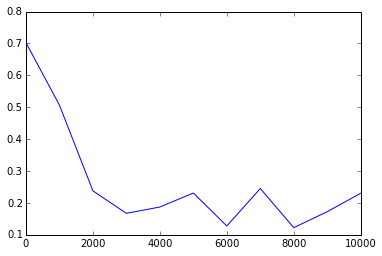

In [17]:
# setup task and agent
NUM_EPISODES = 10001
grid_task = GridWorld(grid, rewards, wall_penalty=0., gamma=0.9, tabular=False)
dqn = DQN(grid_task, hidden_dim=128, l2_reg=0.0, lr=0.05, epsilon=0.15)
# run the experiment
grid_experiment(dqn, grid_task, NUM_EPISODES, diagnostic_callback=compute_value_function, diagnostic_frequency=1000)

## Verify the decomposition